In [52]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

In [53]:
import tensorflow as tf
import os
from tensorflow.keras import layers, models
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [54]:
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import plotly.express as px
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [55]:
data = pd.read_csv("/content/ngpf_data (1).csv")

In [56]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6321 entries, 0 to 6320
Data columns (total 2 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Day                               6321 non-null   object 
 1   Price in Dollars per Million Btu  6320 non-null   float64
dtypes: float64(1), object(1)
memory usage: 98.9+ KB


In [57]:
data['Day'] = pd.to_datetime(data['Day'], format = "%d/%m/%Y")


In [58]:
data.head(3)

,Day,Price in Dollars per Million Btu
0,2022-03-01,4.36
1,2022-02-28,4.46
2,2022-02-25,4.63


In [59]:
data.tail(3)

,Day,Price in Dollars per Million Btu
6318,1997-01-09,3.61
6319,1997-01-08,3.80
6320,1997-01-07,3.82


In [60]:
data.describe()

,Day,Price in Dollars per Million Btu
count,6321,6320.000000
mean,2009-08-15 09:04:28.248695040,4.153691
min,1997-01-07 00:00:00,1.050000
25%,2003-04-30 00:00:00,2.660000
50%,2009-09-01 00:00:00,3.520000
75%,2015-12-03 00:00:00,5.160000
max,2022-03-01 00:00:00,23.860000
std,NaN,2.164102


In [61]:
#renaming
data = data.rename({'Day': 'date', 'Price in Dollars per Million Btu': 'gas_price'}, axis = 1)


In [62]:
data = data.set_index('date')

In [63]:
data.tail(3)

,gas_price
date,
1997-01-09,3.61
1997-01-08,3.80
1997-01-07,3.82


In [64]:
print(data.isnull().sum())

gas_price    1
dtype: int64


In [65]:
#if there is any missing value in the  data ,we fill it with previous day's price
data = data.fillna(method = 'pad')
print(data.isnull().sum())

gas_price    0
dtype: int64


In [66]:
fig = px.line(data, title = 'Natural Gas Spot Prices', template = 'plotly_dark')
fig.show()

In [67]:
fig = px.histogram(data, x = "gas_price", template = 'plotly_dark')
fig.show()

In [68]:
def test_stationarity(timeseries):

    # Determing rolling statistics
    rolmean = timeseries.rolling(25).mean()
    rolstd = timeseries.rolling(25).std()

    # Plot rolling statistics:
    plt.figure(figsize = (20,10))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag = 'AIC')
    dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value

    print(dfoutput)

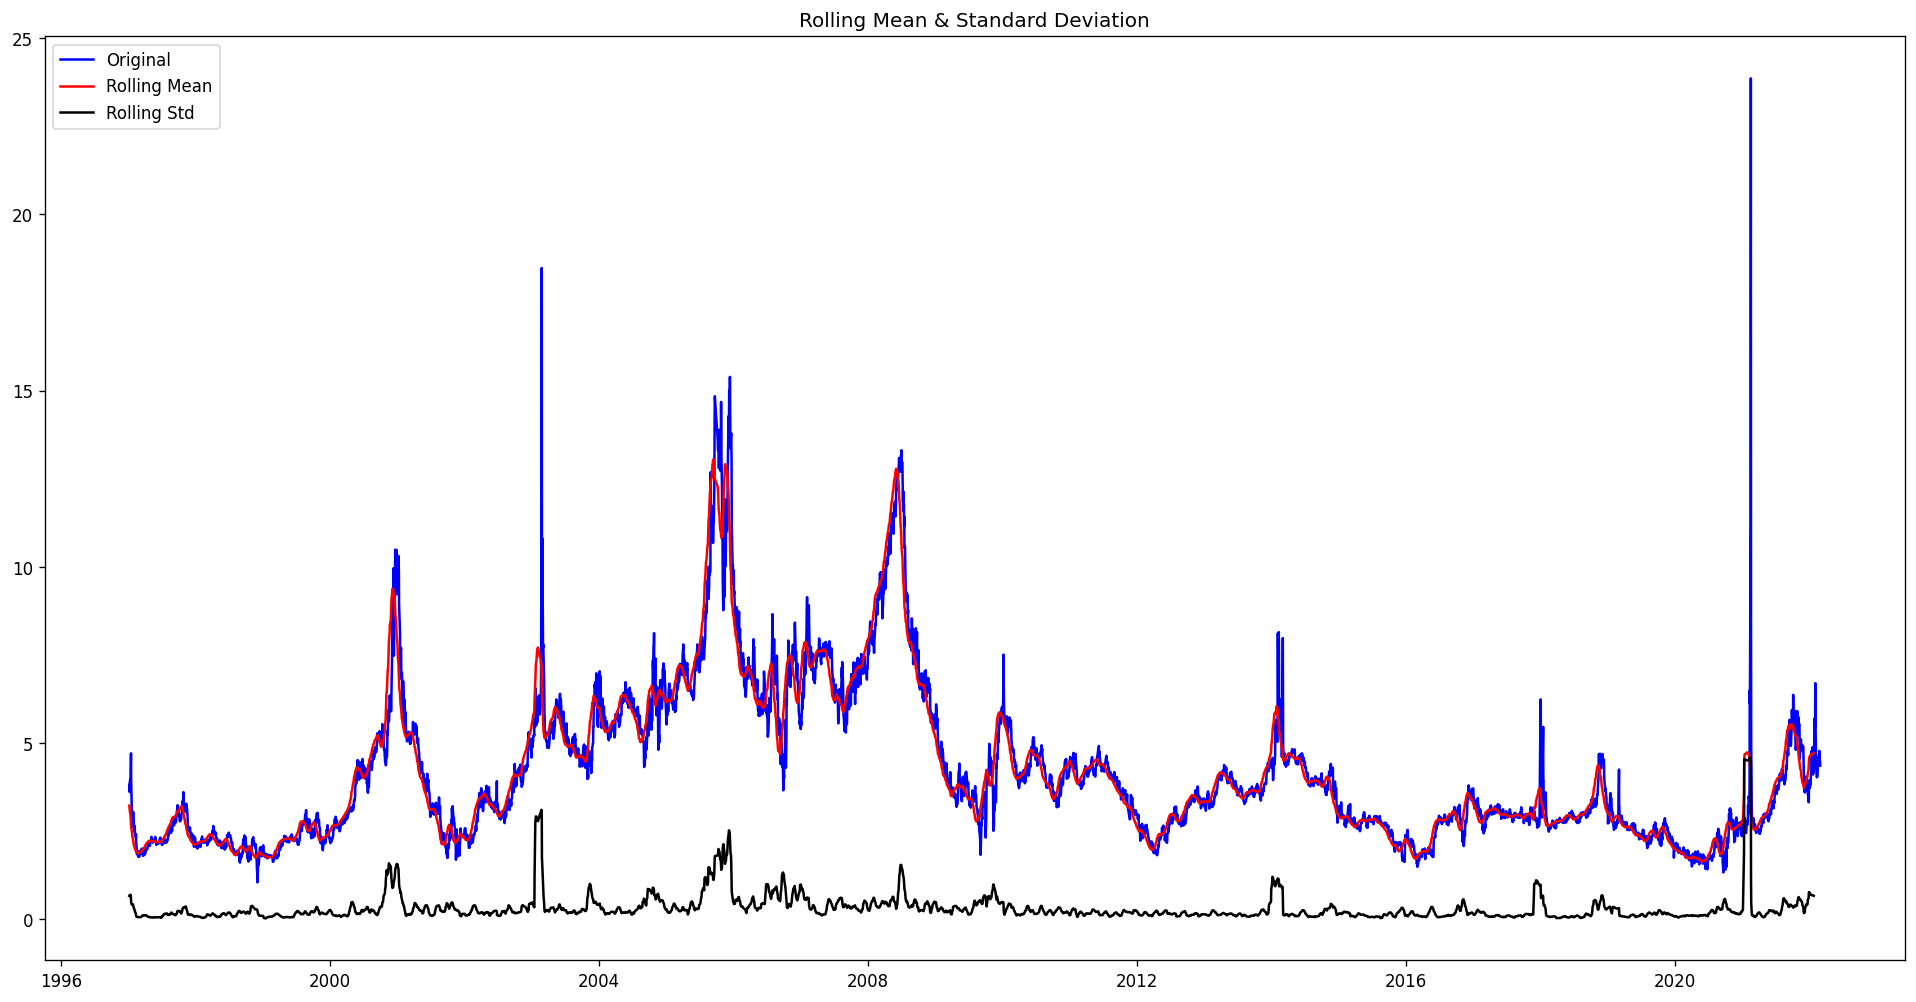

Results of Dickey-Fuller Test:
Test Statistic                   -3.867920
p-value                           0.002284
#Lags Used                        8.000000
Number of Observations Used    6312.000000
Critical Value (1%)              -3.431386
Critical Value (5%)              -2.861998
Critical Value (10%)             -2.567014
dtype: float64


In [69]:
test_stationarity(data)

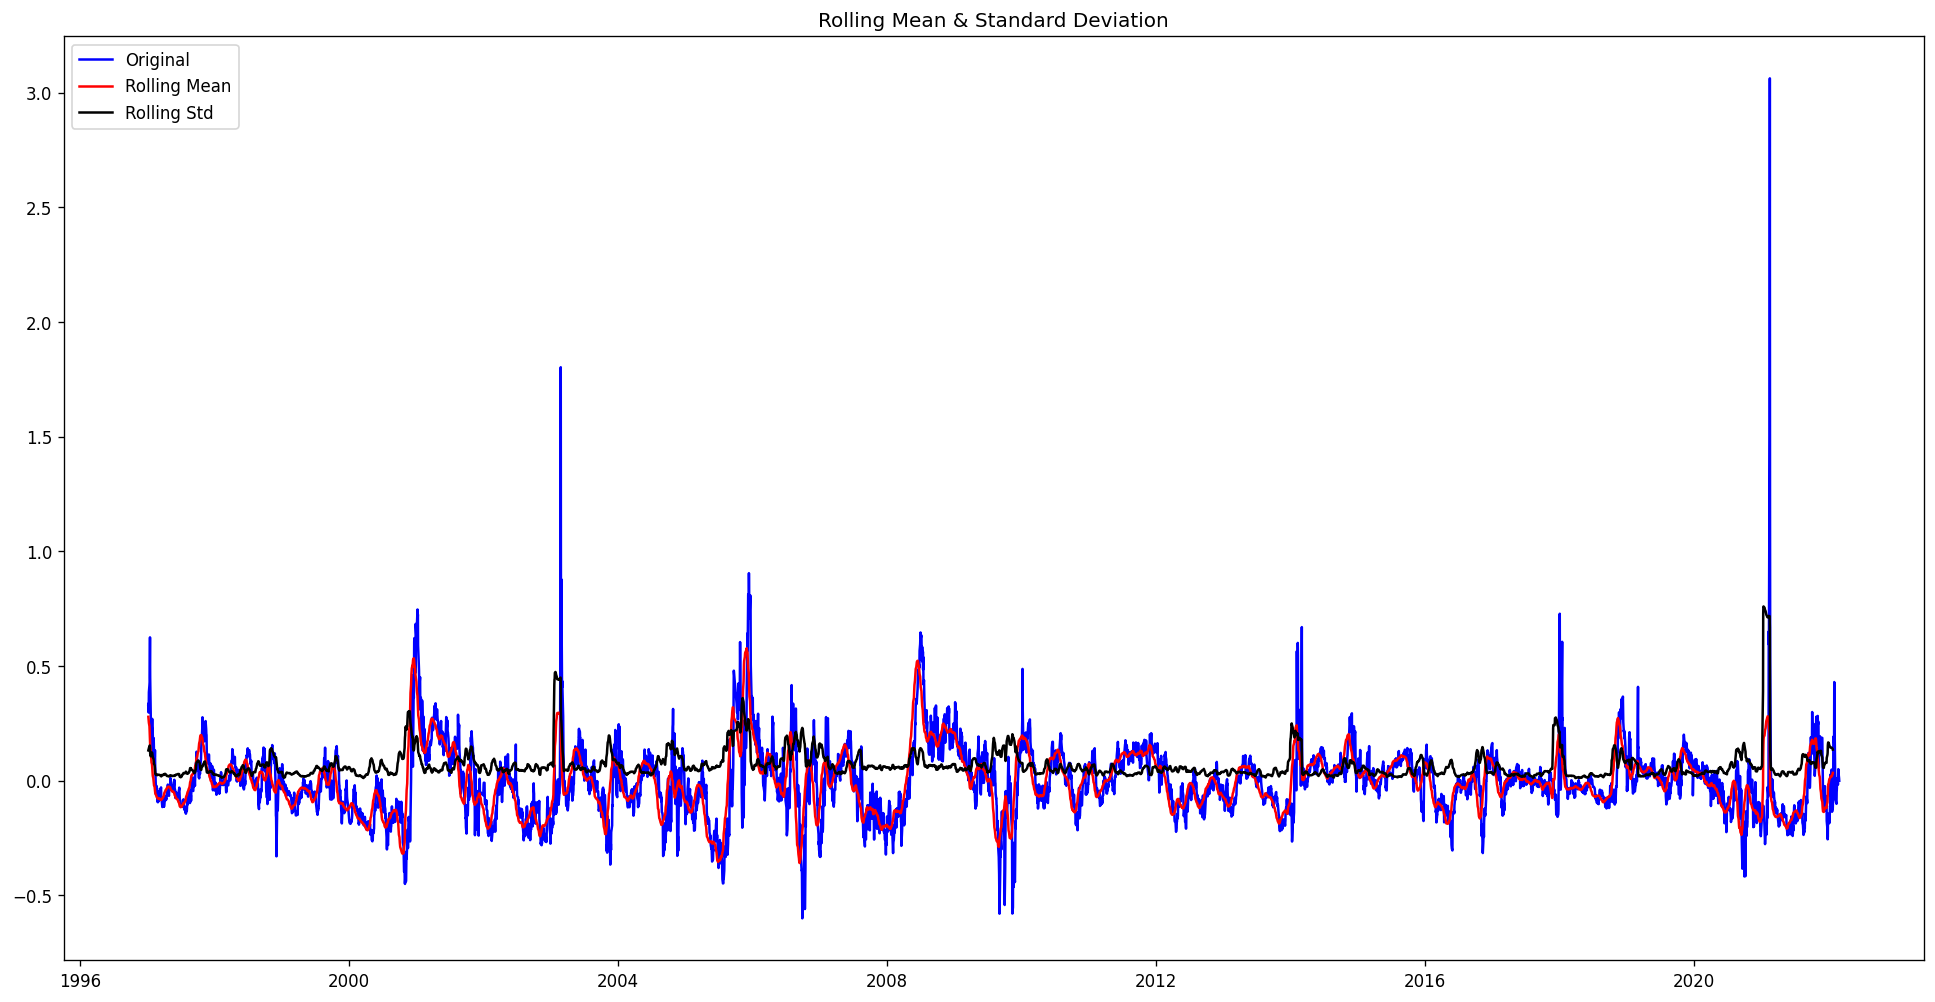

Results of Dickey-Fuller Test:
Test Statistic                -1.125358e+01
p-value                        1.688509e-20
#Lags Used                     1.000000e+01
Number of Observations Used    6.310000e+03
Critical Value (1%)           -3.431387e+00
Critical Value (5%)           -2.861998e+00
Critical Value (10%)          -2.567014e+00
dtype: float64


In [70]:
ts_sqrt = np.sqrt(data)
expwighted_avg = ts_sqrt.ewm(halflife = 25).mean()

ts_sqrt_ewma_diff = ts_sqrt - expwighted_avg
test_stationarity(ts_sqrt_ewma_diff)

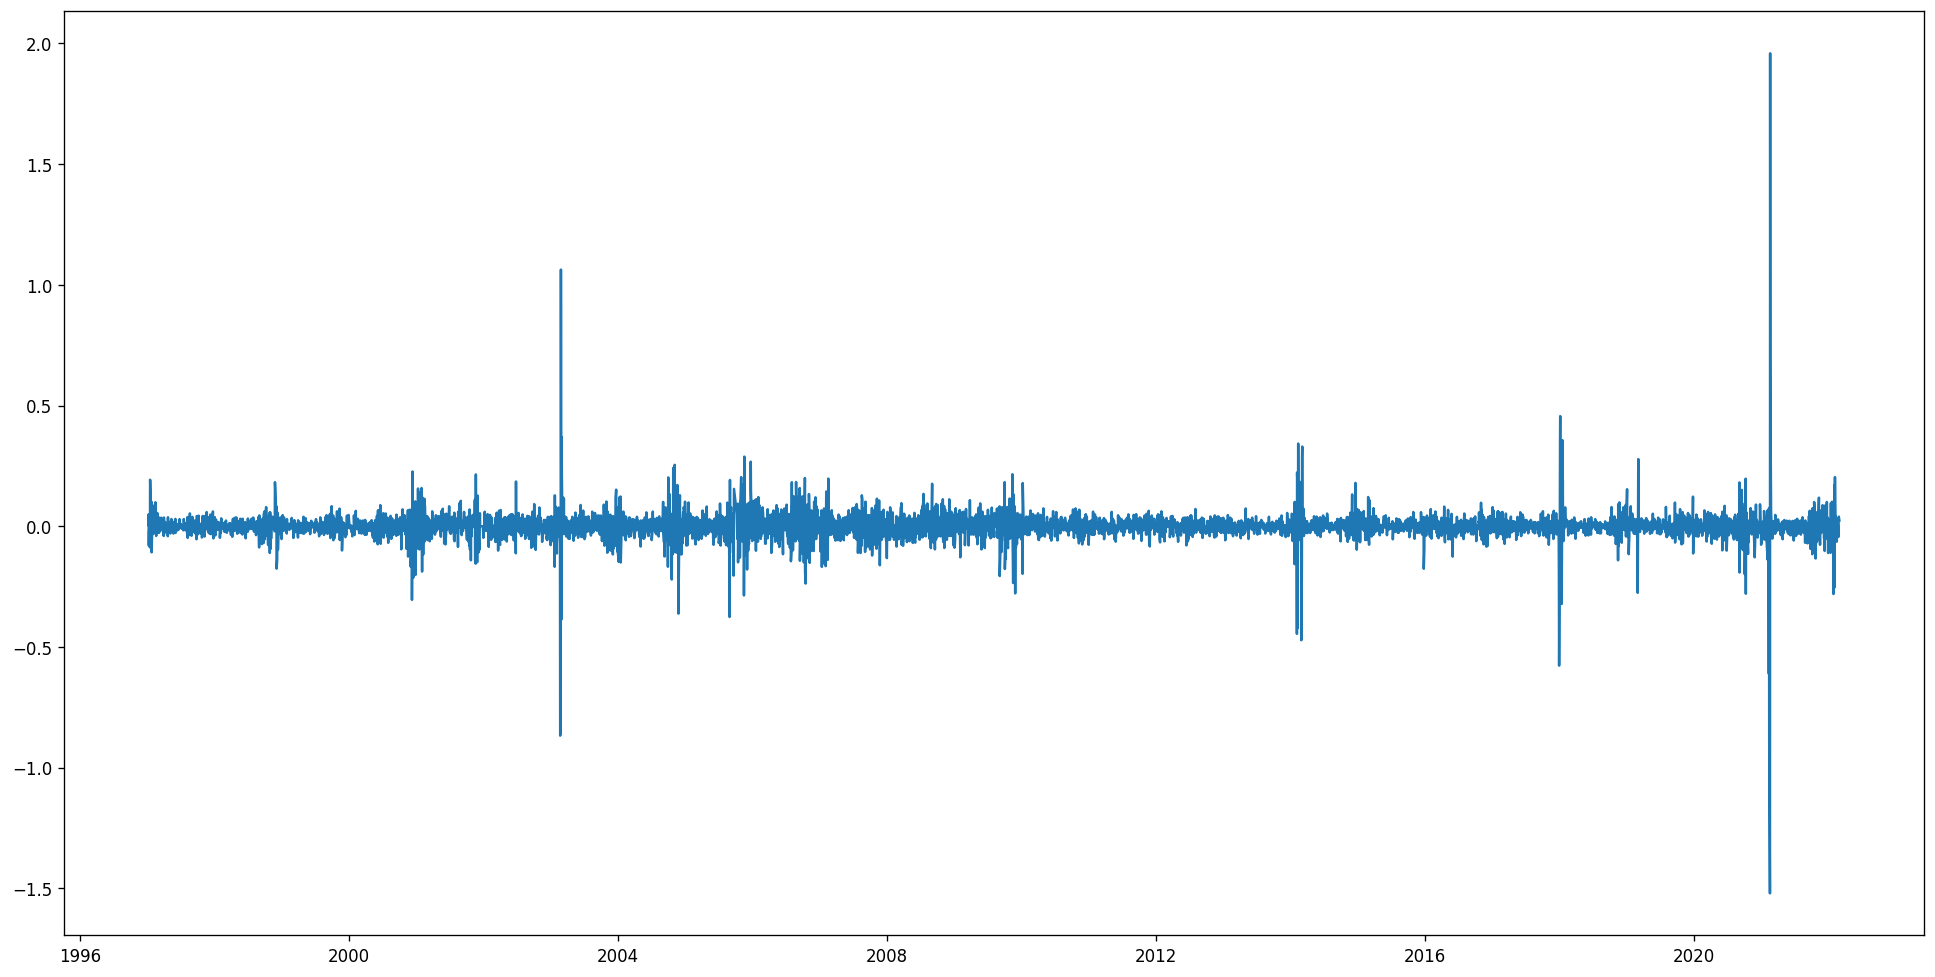

In [71]:
ts_sqrt_diff = ts_sqrt - ts_sqrt.shift()

plt.figure(figsize = (20,10))
plt.plot(ts_sqrt_diff)
plt.show()

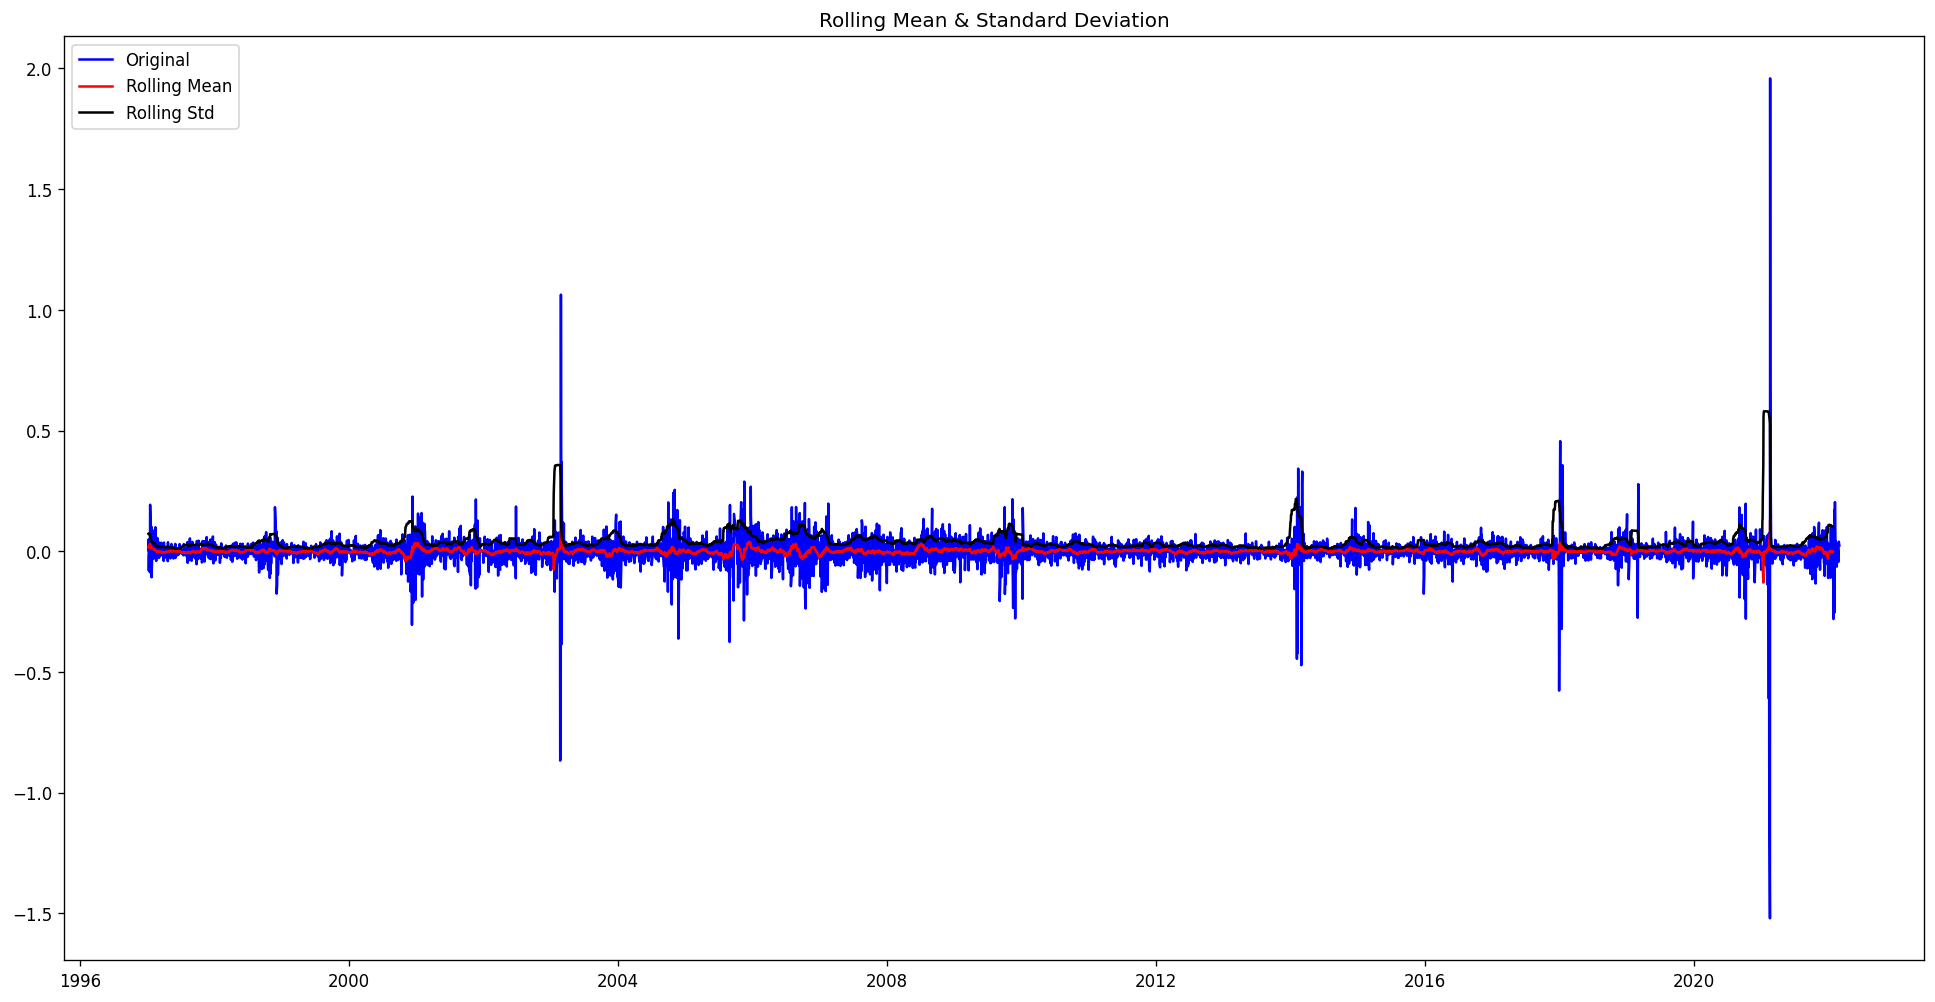

Results of Dickey-Fuller Test:
Test Statistic                  -25.917790
p-value                           0.000000
#Lags Used                       11.000000
Number of Observations Used    6308.000000
Critical Value (1%)              -3.431387
Critical Value (5%)              -2.861998
Critical Value (10%)             -2.567014
dtype: float64


In [72]:
ts_sqrt = np.sqrt(data)
ts_sqrt_diff = ts_sqrt - ts_sqrt.shift()
ts_sqrt_diff.dropna(inplace = True)
test_stationarity(ts_sqrt_diff)

In [73]:
data = data.sort_values(by = 'date')

train = data['1997-01-06': '2020-01-06'] # 7 Jan 1997 to 6 Jan 2021
test = data['2020-01-07': '2022-03-01'] # 7 Jan 2021  to 1 Mar 2022

print("Length of Train Data: ", len(train))
print("Length of Test Data: ", len(test))

Length of Train Data:  5783
Length of Test Data:  538


In [74]:
train.head(5)

,gas_price
date,
1997-01-07,3.82
1997-01-08,3.80
1997-01-09,3.61
1997-01-10,3.92
1997-01-13,4.00


In [75]:
train.tail(5)

,gas_price
date,
2019-12-30,2.06
2019-12-31,2.09
2020-01-02,2.05
2020-01-03,2.06
2020-01-06,2.10


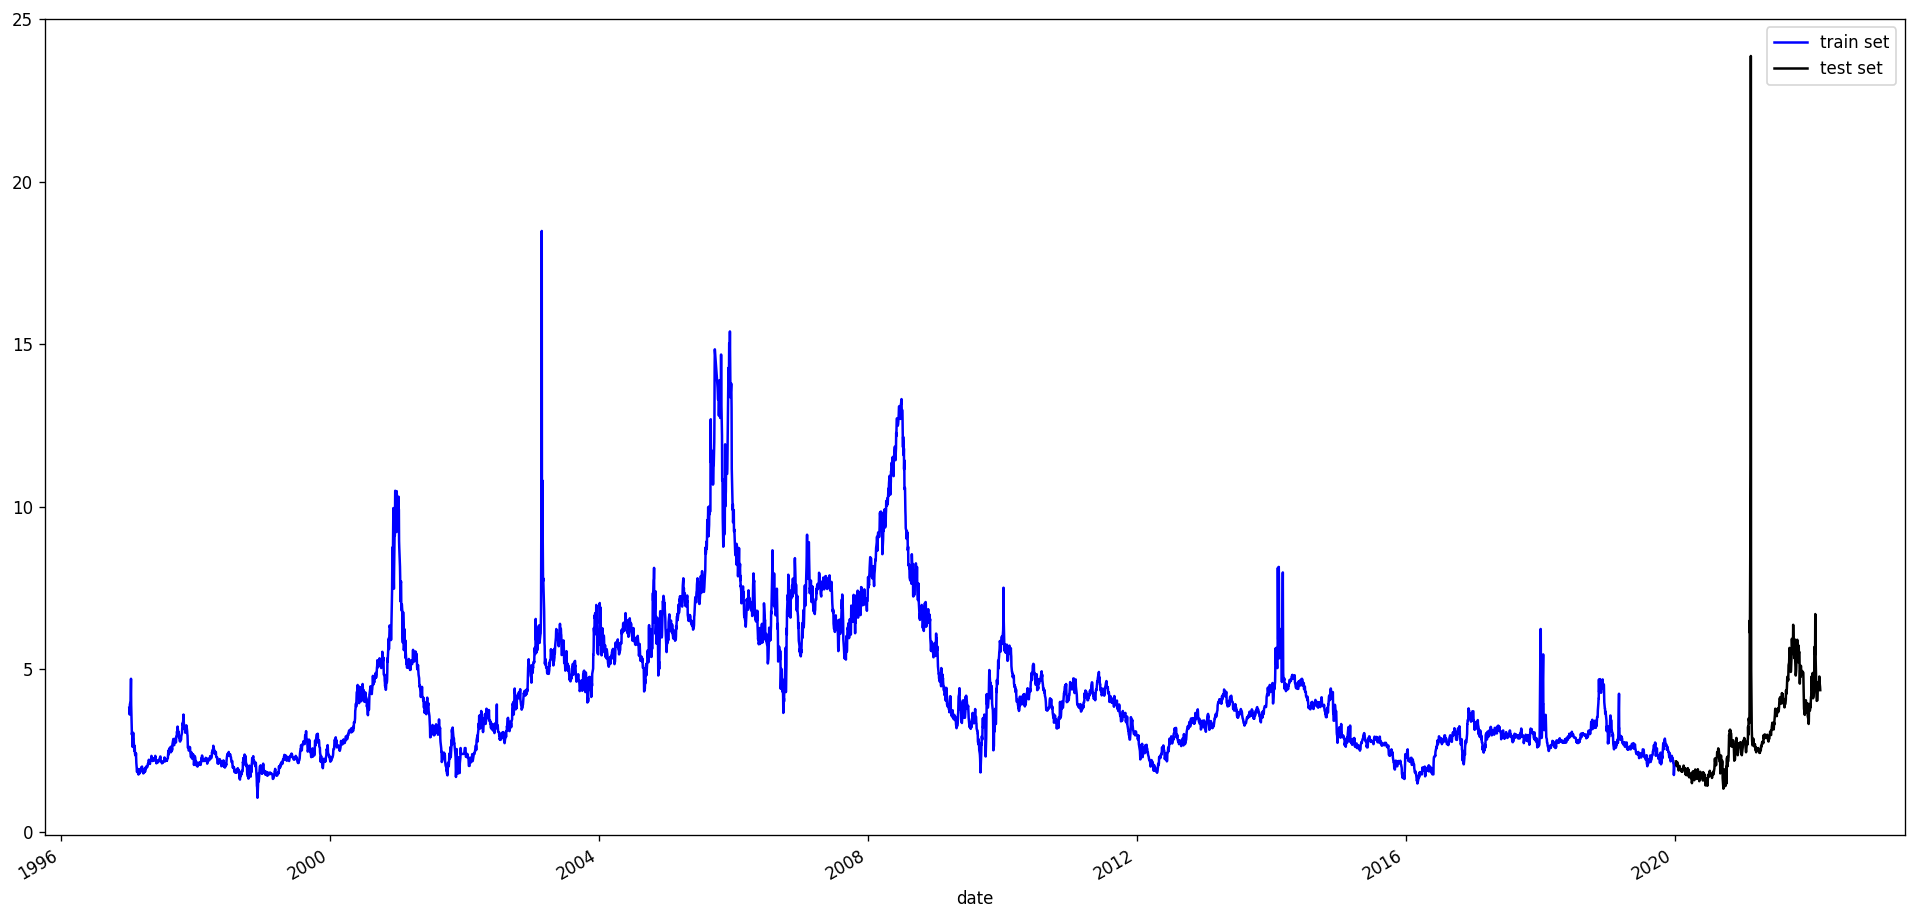

In [76]:
ax = train.plot(figsize = (20, 10), color = 'b')
test.plot(ax = ax, color = 'black')
plt.legend(['train set', 'test set'])
plt.show()

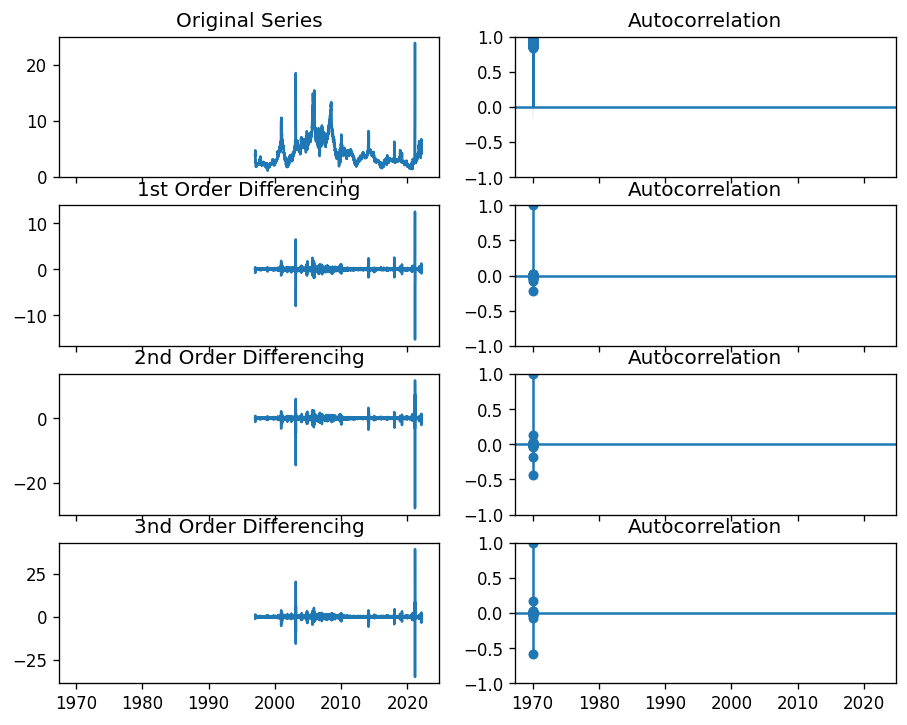

In [77]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(4, 2, sharex=True)
axes[0, 0].plot(data.gas_price); axes[0, 0].set_title('Original Series')
plot_acf(data.gas_price, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(data.gas_price.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(data.gas_price.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(data.gas_price.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(data.gas_price.diff().diff().dropna(), ax=axes[2, 1])

# 3rd Differencing
axes[3, 0].plot(data.gas_price.diff().diff().diff()); axes[3, 0].set_title('3nd Order Differencing')
plot_acf(data.gas_price.diff().diff().diff().dropna(), ax=axes[3, 1])

plt.show()

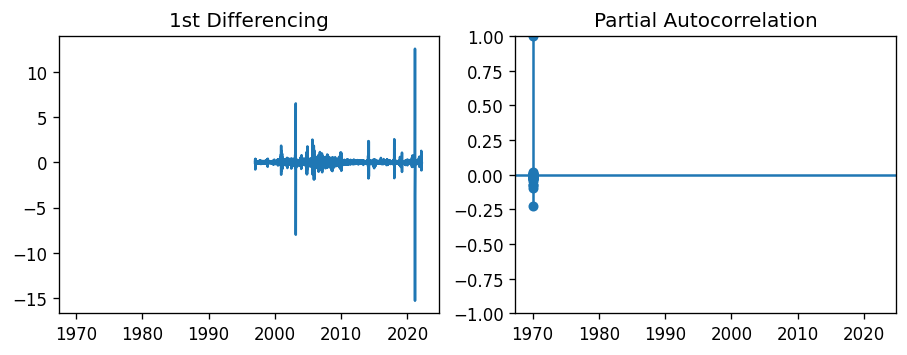

In [78]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(data.gas_price.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(data.gas_price.diff().dropna(), ax=axes[1])

plt.show()

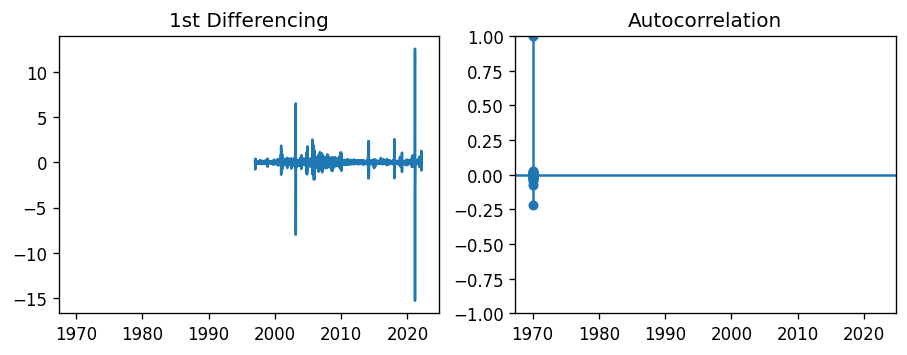

In [79]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)

axes[0].plot(data.gas_price.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(data.gas_price.diff().dropna(), ax=axes[1])

plt.show()

In [80]:
model = sm.tsa.arima.ARIMA(train, order = (1, 2, 1))
arima_model = model.fit()
print(arima_model.summary())

                               SARIMAX Results                                
Dep. Variable:              gas_price   No. Observations:                 5783
Model:                 ARIMA(1, 2, 1)   Log Likelihood                -667.664
Date:                Sun, 15 Dec 2024   AIC                           1341.328
Time:                        09:23:59   BIC                           1361.315
Sample:                             0   HQIC                          1348.282
                               - 5783                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0093      0.002      5.149      0.000       0.006       0.013
ma.L1         -1.0000      0.038    -26.429      0.000      -1.074      -0.926
sigma2         0.0737      0.003     26.664      0.0

In [81]:
yp_train = arima_model.predict(start = 0, end = (len(train)-1))
yp_test = arima_model.predict(start = 0, end = (len(test)-1))

print("Train Data:\nMean Square Error: {}".format(mean_squared_error(train, yp_train)))
print("\nTest Data:\nMean Square Error: {}".format(mean_squared_error(test, yp_test)))

Train Data:
Mean Square Error: 0.07688605689507726

Test Data:
Mean Square Error: 3.8213614143864163


In [82]:
print(yp_test)

date
1997-01-07    0.000000
1997-01-08    5.730000
1997-01-09    3.780000
1997-01-10    3.504213
1997-01-13    3.956581
                ...   
1999-02-22    1.786127
1999-02-23    1.766004
1999-02-24    1.745974
1999-02-25    1.725944
1999-02-26    1.635135
Name: predicted_mean, Length: 538, dtype: float64


In [83]:
print(test)

            gas_price
date                 
2020-01-07       2.17
2020-01-08       2.09
2020-01-09       2.05
2020-01-10       2.05
2020-01-13       2.03
...               ...
2022-02-23       4.59
2022-02-24       4.78
2022-02-25       4.63
2022-02-28       4.46
2022-03-01       4.36

[538 rows x 1 columns]


In [84]:
print(yp_train)

date
1997-01-07    0.000000
1997-01-08    5.730000
1997-01-09    3.780000
1997-01-10    3.504213
1997-01-13    3.956581
                ...   
2019-12-30    1.746493
2019-12-31    2.062568
2020-01-02    2.089980
2020-01-03    2.049324
2020-01-06    2.059789
Name: predicted_mean, Length: 5783, dtype: float64


In [85]:
print(train)

            gas_price
date                 
1997-01-07       3.82
1997-01-08       3.80
1997-01-09       3.61
1997-01-10       3.92
1997-01-13       4.00
...               ...
2019-12-30       2.06
2019-12-31       2.09
2020-01-02       2.05
2020-01-03       2.06
2020-01-06       2.10

[5783 rows x 1 columns]


In [86]:
slot = 15

x_train = []
y_train = []

for i in range(slot, len(train)):
    x_train.append(train.iloc[i-slot:i, 0])
    y_train.append(train.iloc[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
print(x_train.shape, y_train.shape)

(5768, 15, 1) (5768,)


In [87]:
lstm_model = tf.keras.Sequential()
lstm_model.add(tf.keras.layers.LSTM(units = 50, input_shape = (slot, 1), return_sequences = True, activation = 'relu'))
#lstm_model.add(tf.keras.layers.Dropout(0.01))
lstm_model.add(tf.keras.layers.LSTM(units = 50, activation = 'relu', return_sequences = True))
#lstm_model.add(tf.keras.layers.Dropout(0.01))
lstm_model.add(tf.keras.layers.LSTM(units = 50, return_sequences = True))
#lstm_model.add(tf.keras.layers.Dropout(0.01))
lstm_model.add(tf.keras.layers.LSTM(units = 50, return_sequences = False))
#lstm_model.add(tf.keras.layers.Dropout(0.01))
lstm_model.add(tf.keras.layers.Dense(units = 1))
lstm_model.compile(loss = 'mean_squared_error', optimizer = 'adam')

lstm_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 15, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 15, 50)              │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ (None, 15, 50)              │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 71,051 (277.54 KB)

 Trainable params: 71,051 (277.54 KB)

 Non-trainable params: 0 (0.00 B)

In [88]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 7)

history = lstm_model.fit(x_train, y_train, epochs = 50,
                         batch_size = 64,
                         verbose = 1, shuffle = False,
                         callbacks = [early_stopping])

Epoch 1/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 4.5526
Epoch 2/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 2.8130
Epoch 3/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 1.7037
Epoch 4/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 1.3819
Epoch 5/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.9904
Epoch 6/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - loss: 0.6073
Epoch 7/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.5198
Epoch 8/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.4647
Epoch 9/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - loss: 0.4501
Epoch 10/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.4255
Epoch 11/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.4127
Epoch 12/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - loss: 0.4051
Epoch 13/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - loss: 0.3843
Epoch 14/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.3681
Epoch 15/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.3406
Epoc

In [91]:
p_train = lstm_model.predict(x_train)
a = pd.DataFrame(p_train) # Use p_train instead of yp_train
a.rename(columns = {0: 'gp_pred'}, inplace = True);
a.index = train.index[slot:slot + len(p_train)]
train_compare = pd.concat([train.iloc[slot:], a],axis= 1)

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step


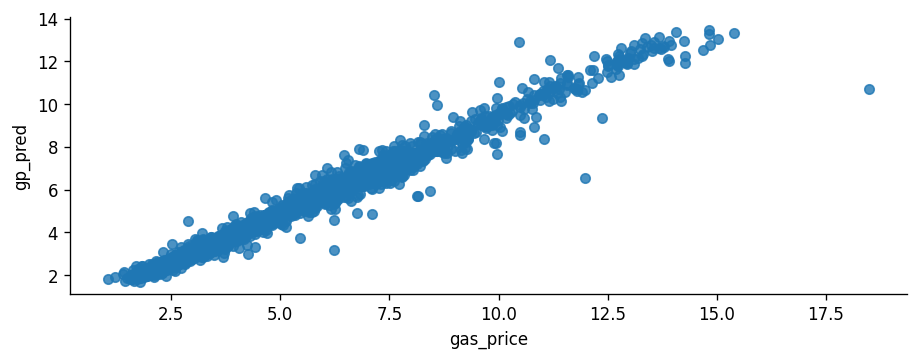

In [92]:
from matplotlib import pyplot as plt
train_compare.plot(kind='scatter', x='gas_price', y='gp_pred', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

In [93]:
train_compare.head(3)

,gas_price,gp_pred
date,,
1997-01-28,3.05,3.046763
1997-01-29,2.91,3.130802
1997-01-30,2.86,3.109109


In [94]:
train_compare.tail(3)

,gas_price,gp_pred
date,,
2020-01-02,2.05,2.185865
2020-01-03,2.06,2.206625
2020-01-06,2.10,2.220653


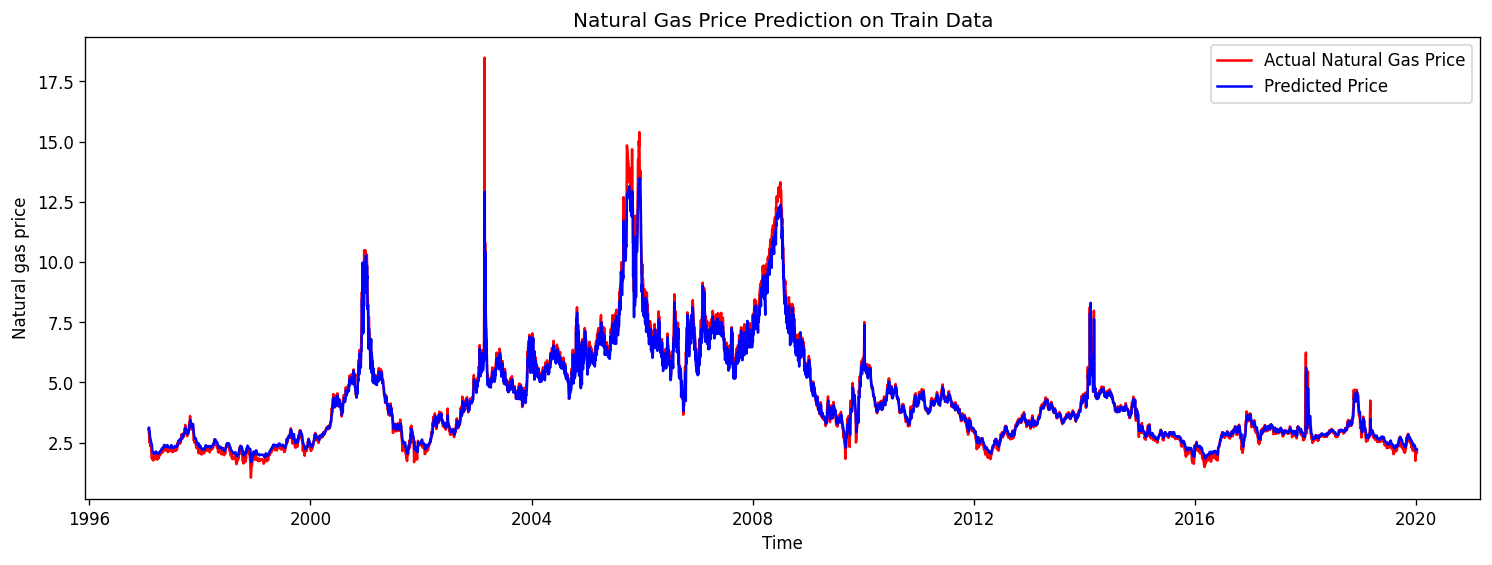

In [95]:
plt.figure(figsize = (15, 5))
plt.plot(train_compare['gas_price'], color = 'red', label = "Actual Natural Gas Price")
plt.plot(train_compare['gp_pred'], color = 'blue', label = 'Predicted Price')
plt.title("Natural Gas Price Prediction on Train Data")
plt.xlabel('Time')
plt.ylabel('Natural gas price')
plt.legend(loc = 'best')
plt.show()

In [96]:
dataset_total = pd.concat((train, test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(test)- slot:].values
inputs = inputs.reshape(-1, 1)

x_test = []
y_test = []
for i in range (slot, len(test)+slot): #Test+15
    x_test.append(inputs[i-slot:i, 0])
    y_test.append(train.iloc[i, 0])

x_test, y_test = np.array(x_test), np.array(y_test)

x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
pred_price = lstm_model.predict(x_test)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


In [97]:
b = pd.DataFrame(pred_price)
b.rename(columns = {0: 'gp_pred'}, inplace = True);
b.index = test.index
test_compare = pd.concat([test, b],axis= 1)

In [98]:
test_compare.head(5)

,gas_price,gp_pred
date,,
2020-01-07,2.17,2.235838
2020-01-08,2.09,2.261793
2020-01-09,2.05,2.265679
2020-01-10,2.05,2.248562
2020-01-13,2.03,2.228139


In [99]:
test_compare.tail(5)

,gas_price,gp_pred
date,,
2022-02-23,4.59,4.408145
2022-02-24,4.78,4.480436
2022-02-25,4.63,4.648540
2022-02-28,4.46,4.518499
2022-03-01,4.36,4.385728


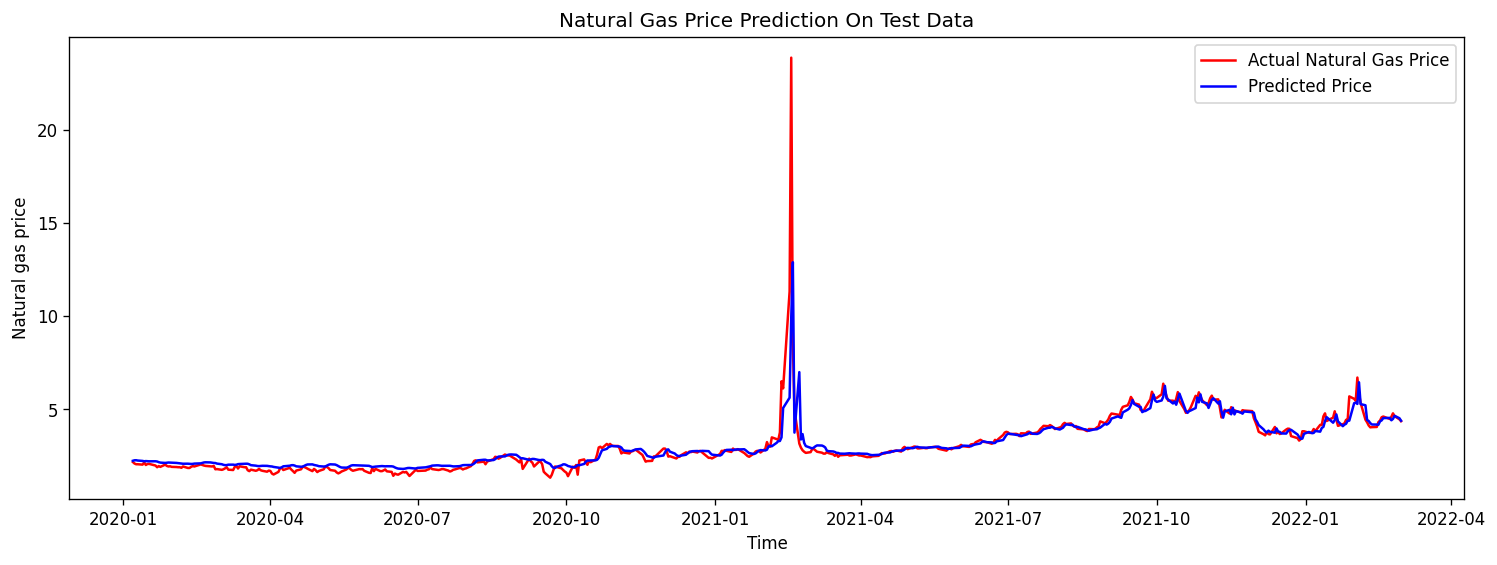

In [100]:
plt.figure(figsize = (15,5))
plt.plot(test_compare['gas_price'], color = 'red', label = "Actual Natural Gas Price")
plt.plot(test_compare['gp_pred'], color = 'blue', label = 'Predicted Price')
plt.title("Natural Gas Price Prediction On Test Data")
plt.xlabel('Time')
plt.ylabel('Natural gas price')
plt.legend(loc = 'best')
plt.show()

In [101]:
mse_train = mean_squared_error(train_compare['gas_price'], train_compare['gp_pred'])
mse_test = mean_squared_error(test_compare['gas_price'], test_compare['gp_pred'])

r2_train = r2_score(train_compare['gas_price'], train_compare['gp_pred'])
r2_test = r2_score(test_compare['gas_price'], test_compare['gp_pred'])

print("Train Data:\nMSE: {}\nR Square: {}".format(mse_train, r2_train))
print("\nTest Data:\nMSE: {}\nR Square: {}".format(mse_test, r2_test))

Train Data:
MSE: 0.11388549480321832
R Square: 0.9761873776238285

Test Data:
MSE: 0.562266657551999
R Square: 0.7722457459139518


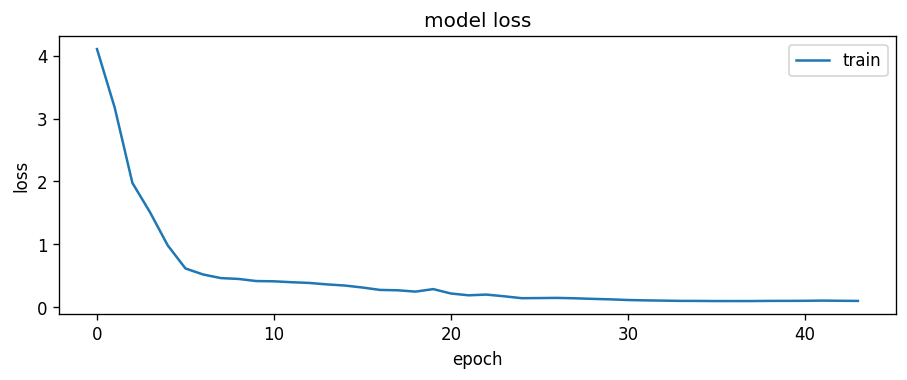

In [102]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')
plt.show()

In [103]:
forecast = pd.DataFrame({'date': pd.date_range(start = '3/2/2022', end = '3/20/2022')}) # 2 March to 20 March

inputs = test[len(test) - slot: ].values

for i in range(slot, len(forecast)):
    inputs = inputs.T
    inputs = np.reshape(inputs, (inputs.shape[0], inputs.shape[1], 1))
    pred_price = lstm_model.predict(inputs[:,i-slot:i])
    inputs = np.append(inputs, pred_price)
    inputs = np.reshape(inputs, (inputs.shape[0], 1))

forecast['gp_pred'] = inputs
forecast = forecast.set_index('date')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


In [104]:
forecast.reset_index(inplace = True)

fig = px.line(forecast, x = "date", y = "gp_pred", title = 'Natural Gas Price Forecasting', template = 'plotly_dark')
fig.show()

In [105]:
train_compare.reset_index(inplace = True)
test_compare.reset_index(inplace = True)

df = pd.concat((train_compare[['date','gp_pred']], test_compare[['date', 'gp_pred']], forecast[['date', 'gp_pred']]), axis = 0)

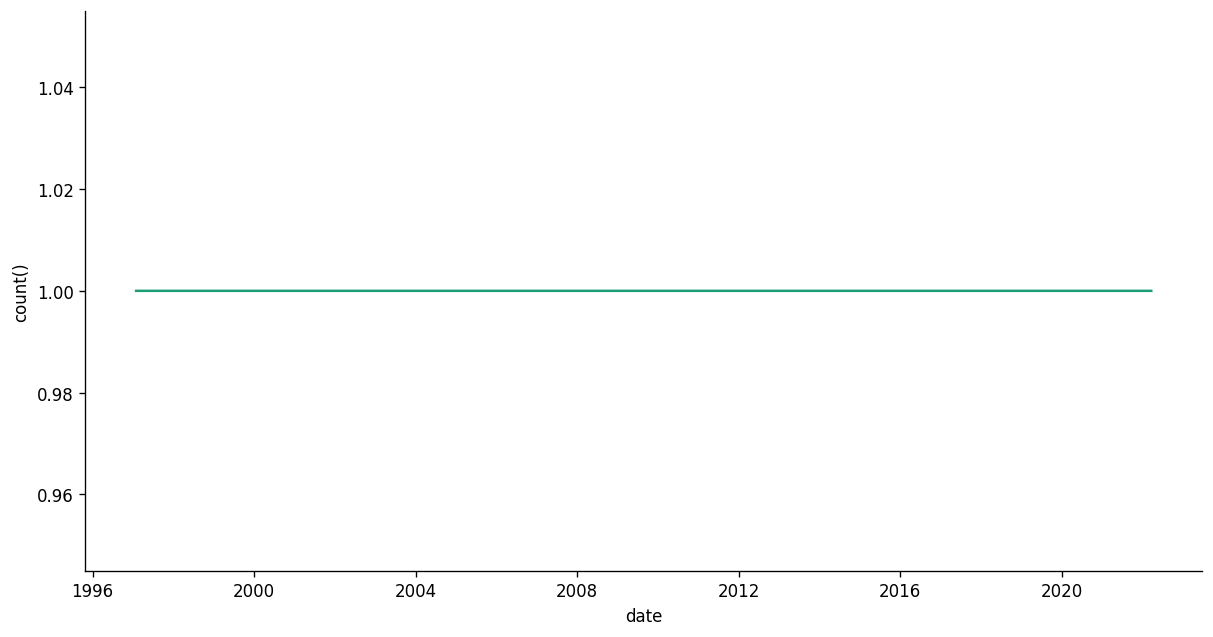

In [106]:
from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['date']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'date'}, axis=1)
              .sort_values('date', ascending=True))
  xs = counted['date']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('count()')

In [107]:
df.head(5)

,date,gp_pred
0,1997-01-28,3.046763
1,1997-01-29,3.130802
2,1997-01-30,3.109109
3,1997-01-31,3.051161
4,1997-02-03,2.970755


In [108]:
df.tail(5)

,date,gp_pred
14,2022-03-16,4.360000
15,2022-03-17,4.313242
16,2022-03-18,4.285803
17,2022-03-19,4.270687
18,2022-03-20,4.261280


In [109]:
df.to_csv("predicted_price.csv", index = False)
lstm_model.save("lstm_model.h5")

In [110]:
from sklearn.metrics import mean_squared_error, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Dropout
from tensorflow.keras.optimizers import Adam

In [113]:
from sklearn.metrics import mean_squared_error, r2_score

# Calculate ARIMA model accuracy
arima_mse = mean_squared_error(test, yp_test)
arima_rmse = np.sqrt(arima_mse)
arima_r2 = r2_score(test, yp_test)
arima_accuracy = 1 - arima_mse / np.var(test)  # Simple accuracy estimate for ARIMA

print(f"ARIMA MSE: {arima_mse:.4f}")
print(f"ARIMA RMSE: {arima_rmse:.4f}")
print(f"ARIMA R-squared: {arima_r2:.4f}")
print(f"ARIMA Accuracy: {arima_accuracy.iloc[0]:.4f}")
pred_price = lstm_model.predict(x_test)
pred_price = pred_price.flatten()
# Calculate LSTM model accuracy
lstm_mse = mean_squared_error(y_test, pred_price)
lstm_rmse = np.sqrt(lstm_mse)
lstm_r2 = r2_score(y_test, pred_price)
lstm_accuracy = 1 - lstm_mse / np.var(y_test)  # Simple accuracy estimate for LSTM

print(f"LSTM MSE: {lstm_mse:.4f}")
print(f"LSTM RMSE: {lstm_rmse:.4f}")
print(f"LSTM R-squared: {lstm_r2:.4f}")
print(f"LSTM Accuracy: {lstm_accuracy:.4f}")

ARIMA MSE: 3.8214
ARIMA RMSE: 1.9548
ARIMA R-squared: -0.5479
ARIMA Accuracy: -0.5479
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
LSTM MSE: 2.8561
LSTM RMSE: 1.6900
LSTM R-squared: -18.6715
LSTM Accuracy: -18.6715


In [117]:
# Import necessary libraries
from sklearn.metrics import mean_squared_error, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Dropout
from tensorflow.keras.optimizers import Adam

# Assuming x_train, y_train, x_test, y_test are already defined

# Define the Bidirectional LSTM model
bilstm_model = Sequential()
bilstm_model.add(Bidirectional(LSTM(units=50, activation='relu', return_sequences=True), input_shape=(x_train.shape[1], 1)))
bilstm_model.add(Dropout(0.2))  # Add dropout for regularization
bilstm_model.add(Bidirectional(LSTM(units=50, activation='relu')))
bilstm_model.add(Dropout(0.2))
bilstm_model.add(Dense(units=1))

# Compile the model
bilstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Train the model (if not already trained)
bilstm_model.fit(x_train, y_train, epochs=50, batch_size=32)



Epoch 1/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - loss: 6.4857
Epoch 2/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - loss: 0.4653
Epoch 3/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - loss: 0.4147
Epoch 4/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 12s 67ms/step - loss: 0.3652
Epoch 5/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 15s 36ms/step - loss: 0.3436
Epoch 6/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.3508
Epoch 7/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - loss: 0.2886
Epoch 8/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.2896
Epoch 9/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - loss: 0.3057
Epoch 10/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.3197
Epoch 11/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - loss: 0.2656
Epoch 12/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.2470
Epoch 13/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - loss: 0.2433
Epoch 14/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - loss: 0.2921
Epoch 15/50
181/181 ━━━━━━━━━━━━━━━━━

In [119]:
bilstm_accuracy = bilstm_model.evaluate(x_test, y_test, verbose=0)
print(f"BiLSTM Accuracy (Loss): {bilstm_accuracy:.4f}")

BiLSTM Accuracy (Loss): 4.9246


In [122]:
accuracies = {
    'ARIMA': arima_accuracy.iloc[0],  # Extract the numeric value from the Series
    'LSTM': lstm_accuracy,
    'BiLSTM': bilstm_accuracy
}

In [123]:
best_model_name = max(accuracies, key=accuracies.get)
print(f"Best Model: {best_model_name} with Accuracy: {accuracies[best_model_name]:.4f}")

# Save the best model if it's the BiLSTM model
if best_model_name == 'BiLSTM':
    bilstm_model.save('best_model.h5')
    print("BiLSTM model saved.")

Best Model: BiLSTM with Accuracy: 4.9246
BiLSTM model saved.
